In [25]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.sys.path.append('../../evaluation/')
import pickle
import numpy as np
import pandas as pd
import methods
import metrics
import tensorflow as tf
from scipy.stats import spearmanr

data_path = '../../data/simulated_2d/test/'
model_path = './model/'
gmm_path = './predictions_gmm.pkl'


In [26]:
# load data
data = pickle.load(open(data_path+'/input_data.pkl', 'rb'))
targets = pickle.load(open(data_path+'/target_data.pkl', 'rb'))
targets = [
    metrics.output_to_stats_2d(i) for i in targets
]

In [27]:
# predict GMM

if os.path.exists(gmm_path):
    p_gmm = pickle.load(open(gmm_path, 'rb'))
else:
    p_gmm = []
    for c,i in enumerate(data):
        if c%200==0:
            print(c)
        p = methods.predict_gmm(i)
        p_gmm.append([p['mean'], p['covariance']])

    with open(gmm_path, 'wb') as f:
        pickle.dump(p_gmm, f)
        
# compute error
errors_gmm = metrics.get_errors(targets, p_gmm)


In [28]:
# predict NN

os.sys.path.append('../training/')
os.sys.path.append(model_path)
from predict import extract_features

# load model
model = tf.keras.models.load_model(model_path+'/model_checkpoint')
scalery = pickle.load(open(model_path+'/model_y_scaler.pkl', 'rb'))

# extract features
features = np.stack([extract_features(i) for i in data])
features = features[..., np.newaxis]

# predict
p_nn = model.predict(features)
p_nn = scalery.inverse_transform(p_nn) # scale outputs

p_nn = [
    metrics.output_to_stats_2d(i) for i in p_nn
]

# compute error
errors_nn = metrics.get_errors(targets, p_nn)


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


32/32 [==============================] - 0s 2ms/step


In [29]:
def get_error_statistics(errors, acc_threshold=0.98):
    """ Get error statistics
    """
    df = pd.DataFrame({
        'mean_bd': [np.mean(i) for i in errors.values()],
        'median_bd': [np.quantile(i, 0.5) for i in errors.values()],
        'acc_bc_'+str(acc_threshold): [len(np.where(np.exp(-i)>=acc_threshold)[0])/len(i) for i in errors.values()],
    })
    return df


In [30]:
errors = {
    'GMM': errors_gmm,
    'NN': errors_nn
}

df = get_error_statistics(errors)
df.index = errors.keys()
df


,mean_bd,median_bd,acc_bc_0.98
GMM,0.019885,0.007340,0.724
NN,0.010206,0.005304,0.882


In [31]:
with open('./errors.pkl', 'wb') as f:
    pickle.dump(errors, f)
    

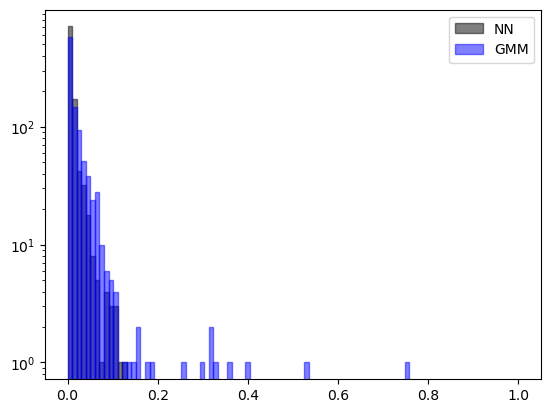

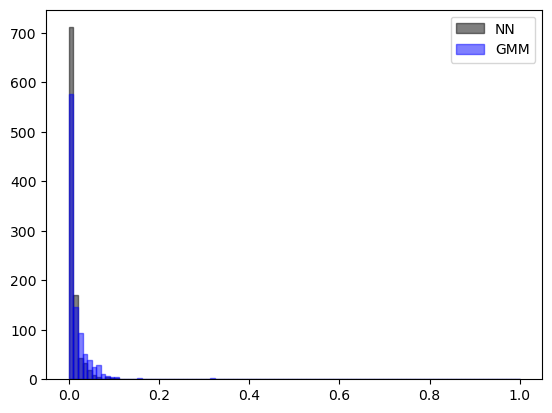

In [32]:
import matplotlib.pyplot as plt

plt.hist(errors['NN'], np.linspace(0, 1.0, 100), edgecolor='k', color='k', alpha=0.5, label='NN');
plt.hist(errors['GMM'], np.linspace(0, 1.0, 100), edgecolor='b', color='b', alpha=0.5, label='GMM');
plt.yscale('log')
plt.legend();

plt.figure()
plt.hist(errors['NN'], np.linspace(0, 1, 100), edgecolor='k', color='k', alpha=0.5, label='NN');
plt.hist(errors['GMM'], np.linspace(0, 1, 100), edgecolor='b', color='b', alpha=0.5, label='GMM');
plt.legend();


In [33]:
means = pickle.load(open(data_path+'/means.pkl', 'rb'))
stds = pickle.load(open(data_path+'/stds.pkl', 'rb'))
sizes = pickle.load(open(data_path+'/sizes.pkl', 'rb'))
corr_mats = pickle.load(open(data_path+'/corr_mats.pkl', 'rb'))


In [34]:
ref_fracs = [i[0]/sum(i) for i in sizes]
bd_dists = []
for i in range(len(data)):
    if len(sizes[i])-1==2:
        bd_dists.append(
            metrics.bhattacharyya_gaussian_distance(
                np.array(means[i][0]),
                metrics.correlation_to_covariance(corr_mats[i][0], stds[i][0]),
                np.array(means[i][1]),
                metrics.correlation_to_covariance(corr_mats[i][1], stds[i][1])
            )
        )
    else:
        bd_dists.append(
            np.mean([
                metrics.bhattacharyya_gaussian_distance(
                    np.array(means[i][0]),
                    metrics.correlation_to_covariance(corr_mats[i][0], stds[i][0]),
                    np.array(means[i][1]),
                    metrics.correlation_to_covariance(corr_mats[i][1], stds[i][1])
                ),
                metrics.bhattacharyya_gaussian_distance(
                    np.array(means[i][0]),
                    metrics.correlation_to_covariance(corr_mats[i][0], stds[i][0]),
                    np.array(means[i][2]),
                    metrics.correlation_to_covariance(corr_mats[i][2], stds[i][2])
                )
            ])
        )


In [35]:
with open('./ref_fracs.pkl', 'wb') as f:
    pickle.dump(ref_fracs, f)
with open('./bd_dists.pkl', 'wb') as f:
    pickle.dump(bd_dists, f)
    

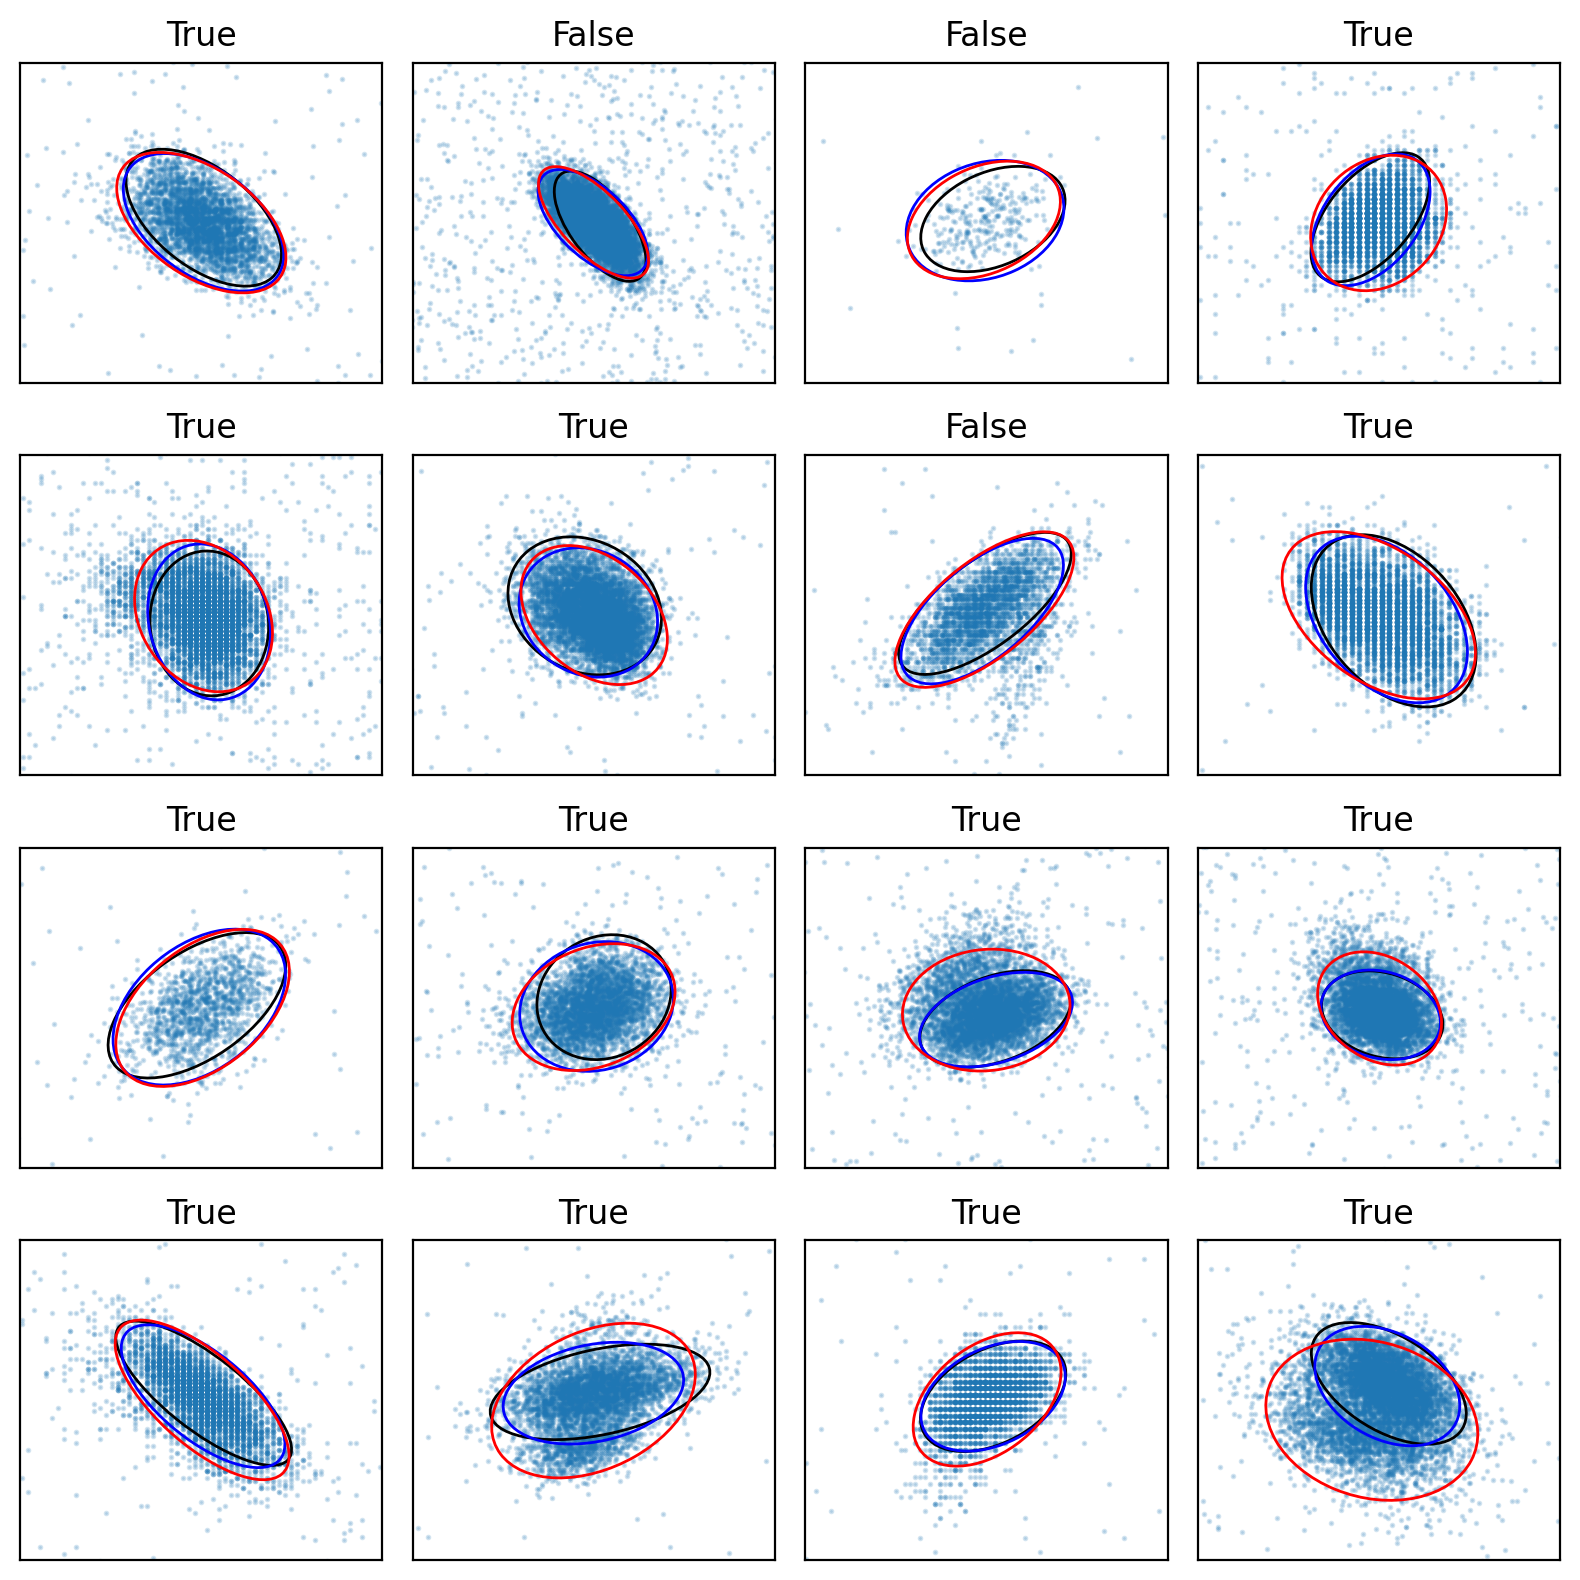

In [36]:
# check examples

predictions = {
    'GMM': p_gmm,
    'NN': p_nn
}

nr = 4
nc = 4

# get examples above or below an error threshold
example_error_score = 0.01
example_error_method = 'GMM'
idx = np.random.choice(np.where((errors[example_error_method]>=example_error_score))[0], nr*nc)

# # or random choice
# idx = np.random.choice(len(errors['NN']), nr*nc)

x_range = np.linspace(-4, 4, 41)

plt.figure(figsize=(8,8), dpi=200)

# sizes = pickle.load(open(data_path+'/sizes.pkl', 'rb'))
# ref_fracs = [i[0]/sum(i) for i in sizes]

for i in range(nr*nc):
    
    plt.subplot(nr, nc, i+1)
    
    plt.scatter(data[idx[i]][:,0], data[idx[i]][:,1], s=1, alpha=0.2)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

    # target
    ell = metrics.plot_cov_ellipse(targets[idx[i]][0].squeeze(), targets[idx[i]][1], edgecolor='k', fc='none')
    plt.gca().add_patch(ell)
    
    # nn
    ell = metrics.plot_cov_ellipse(predictions['NN'][idx[i]][0].squeeze(), predictions['NN'][idx[i]][1], edgecolor='b', fc='none')
    plt.gca().add_patch(ell)
    
    # gmm
    ell = metrics.plot_cov_ellipse(predictions['GMM'][idx[i]][0].squeeze(), predictions['GMM'][idx[i]][1], edgecolor='r', fc='none')
    plt.gca().add_patch(ell)
    
    plt.title(f'{errors["NN"][idx[i]]<errors["GMM"][idx[i]]}')
    
plt.tight_layout()
    